# Spectral Clustering


In this exercise, you will implement spectral clustering and try it on diffent kinds of data, for instance:

* N-blob: Random points in $\mathbb{R}^2$ according to N Gaussian distributions with different means;

* Two moons: Random points shaped as two intertwined moons; 

* Point and circle: random points from a concentrated Gaussian point in the middle and a wide circle around it.

The first step after generating the data is to construct a graph and, for that, we need a similarity function. In this exercise we will use the following similarity:

$$
d(x_i, x_j) = \exp\left(-\frac{||x_i-x_j||_2^2}{2\sigma^2}\right)
$$

Using this similarity, we can compute the weight matrix W representing the graph, compute the graph Laplacian L and finally use its eigenvectors for clustering.


## Setup

In [ ]:
from generate_data import worst_case_blob, blobs, two_moons, point_and_circle
from utils import plot_clusters, min_span_tree, plot_graph_matrix, min_span_tree
from utils import plot_clustering_result, plot_the_bend
from sklearn.cluster import KMeans
import sklearn.metrics as skm
import numpy as np
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import os

## Generating the data

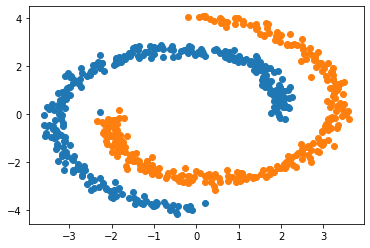

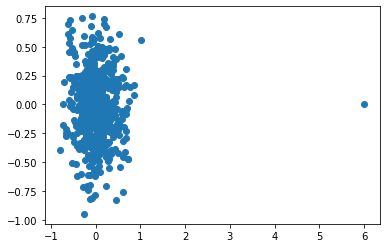

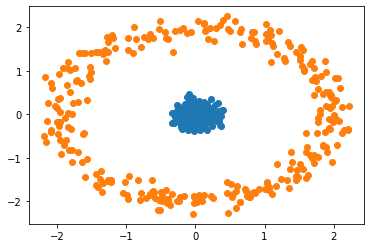

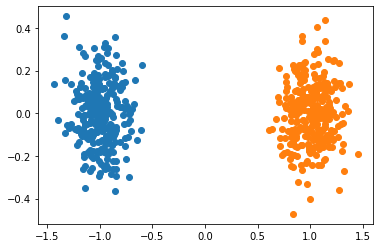

In [ ]:
# Example

for fn in [ two_moons, worst_case_blob, point_and_circle, blobs]:  #  try also [worst_case_blob, point_and_circle, blobs]
    X, Y = fn(num_samples=600)
    plot_clusters(X, Y, fignum=str(fn))
    
# You can check the documentation of each function to see the optional parameters, e.g.:
worst_case_blob?

## Building similarity graph

In [ ]:

def d(x, y, var=1.0):
    return np.exp(-np.sum((x - y)**2)/(2 * var))

def build_similarity_graph(X, var=1.0, eps=0.8, k=0):
    """
    TO BE COMPLETED.

    Computes the similarity matrix for a given dataset of samples. 
    If k=0, builds epsilon graph. 
    Otherwise, builds kNN graph.

    Parameters
    ----------
    X : numpy array
        (n x m) matrix of m-dimensional samples
    var : double 
        the sigma value for the exponential function, already squared
    eps : double
        threshold for epsilon graphs
    k : int
        The number of neighbours k for k-nn. If zero, use epsilon-graph

    Returns
    -------
        W: (n x n) dimensional matrix representing the weight matrix of the graph
    """
    n = X.shape[0]
    W = np.zeros((n, n))

    """
    Build similarity graph, before threshold or kNN
    similarities: (n x n) matrix with similarities between all possible couples of points.
    The similarity function is d(x,y)=exp(-||x-y||^2/(2*var))
    """
  
    similarities = np.zeros((n, n))
    for i in range(n):
        for j in range(i,n):
            x = X[i,:]
            y = X[j,:]
            similarities[i, j] = d(x, y, var)
            similarities[j, i] = similarities[i, j]
    # If epsilon graph
    if k == 0:
        """
        compute an epsilon graph from the similarities             
        for each node x_i, an epsilon graph has weights             
        w_ij = d(x_i,x_j) when w_ij >= eps, and 0 otherwise          
        """
        W = similarities.copy()
        W[W<eps] = 0
        W[np.diag_indices_from(W)] = 0

    # If kNN graph
    elif k != 0:
        """
        compute a k-nn graph from the similarities                   
        for each node x_i, a k-nn graph has weights                  
        w_ij = d(x_i,x_j) for the k closest nodes to x_i, and 0     
        for all the k-n remaining nodes                              
        Remember to remove self similarity and                       
        make the graph undirected                                    
        """
        for i in range(n):
            neighbors = np.argsort(-similarities[i,:])[1:k+1]
            for j in neighbors:
                W[i,j] = similarities[i,j]
                W[j,i] = similarities[i,j]
    return W


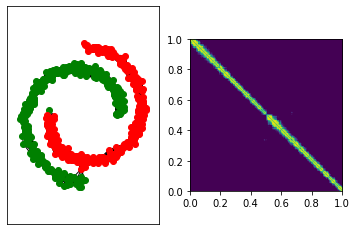

In [ ]:
# Example
X, Y = two_moons(num_samples=600)

W = build_similarity_graph(X)
# W[0, 599] = 1    # add two placeholder edges to reproduce example picture
# W[10, 500] = 1   # 


plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W

## Computing the Laplacian

In [ ]:
def build_laplacian(W, laplacian_normalization='unn'):
    """
    Compute graph Laplacian.

    Parameters
    ----------
    W : numpy array
        Adjacency matrix (n x n)
    laplacian_normalization : str
        String selecting which version of the laplacian matrix to construct.
            'unn':  unnormalized,
            'sym': symmetric normalization
            'rw':  random-walk normalization   

    Returns

    -------
    L: (n x n) dimensional matrix representing the Laplacian of the graph
    """
    L = np.zeros(W.shape)
    degree = np.sum(W, axis=1)
    L = np.diag(degree) - W
    if laplacian_normalization=='sym':
        D_inv = np.diag(1/np.sqrt(degree))
        L = D_inv @ L @ D_inv
    elif laplacian_normalization=='rw':
        D_inv = np.diag(1/degree)
        L = D_inv @ L
    return L

## Clustering

In [ ]:
def spectral_clustering(L, chosen_eig_indices=None, num_classes=2):
    """
    Parameters
    ----------
    L : numpy array
        Graph Laplacian (standard or normalized)
    choosen_eig_indices : list or None
        Indices of eigenvectors to use for clustering. 
        If None, use adaptive choice of eigenvectors.
    num_classes : int 
        Number of clusters to compute (defaults to 2)


    Returns
    -------
    Y : numpy array (num_samples, )
        Cluster assignments
    """

    """
    Use the function scipy.linalg.eig or the function scipy.sparse.linalg.eigs to compute:
    U = (n x n) eigenvector matrix           (sorted)
    E = (n x n) eigenvalue diagonal matrix   (sorted)
    """
    E, U = np.linalg.eigh(L) 

    """
    compute the clustering assignment from the eigenvectors        
    Y = (n x 1) cluster assignments in [0,1,...,num_classes-1]                   
    """
    Y = np.zeros(L.shape[0])
    if chosen_eig_indices:
        U = U[:, chosen_eig_indices]
    else:
        U = U[:, :num_classes]
    Y = KMeans(n_clusters=num_classes).fit_predict(U)
    return Y

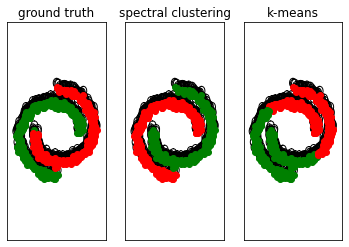

In [ ]:
# Example

num_classes = 2
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

## Parameter sensitivity 

In [ ]:
def parameter_sensitivity(parameter_type, parameter_candidate):
    """
    TO BE COMPLETED.

    A function to test spectral clustering sensitivity to parameter choice.
    """
    # the number of samples to generate
    num_samples = 500

    """
    Choose parameters
    """
    var = 1.0  # exponential_euclidean's sigma^2
    laplacian_normalization = 'unn'
    chosen_eig_indices = None
    parameter_performance = []

    for parameter in parameter_candidate:
        # Generate data
        X, Y = two_moons(num_samples, 1, 0.02)
        num_classes = len(np.unique(Y))
        
        parameter_wrap = {parameter_type: parameter}
        
        W = build_similarity_graph(X, **parameter_wrap)
        L = build_laplacian(W, laplacian_normalization)

        Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes)

        parameter_performance += [skm.adjusted_rand_score(Y, Y_rec)]

    plt.figure()
    plt.plot(parameter_candidate, parameter_performance)
    plt.title(f'parameter sensitivity ({parameter_type})')
    plt.show()

## Image segmentation

In [ ]:
def image_segmentation(filename, num_classes, k=50, var=1, laplacian_normalization = 'unn'):
    """
    TO BE COMPLETED

    Function to perform image segmentation.

    :param input_img: name of the image file in /data (e.g. 'four_elements.bmp' or 'fruit_salad.bmp')
    """
    

    X = io.imread(filename)
    X = (X - np.min(X)) / (np.max(X) - np.min(X))

    im_side = np.size(X, 1)
    Xr = X.reshape(im_side ** 2, 3)
    """
    Y_rec should contain an index from 0 to c-1 where c is the     
     number of segments you want to split the image into          
    """

    """
    Choose parameters
    """
    chosen_eig_indices = None
    

    W = build_similarity_graph(Xr, var=var, k=k)
    L = build_laplacian(W, laplacian_normalization)
    Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes=num_classes)

    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(X)

    plt.subplot(1, 2, 2)
    Y_rec = Y_rec.reshape(im_side, im_side)
    plt.imshow(Y_rec)

    plt.show()

# Questions

In [ ]:
def build_similarity_matrix(X, var=1):
    n = X.shape[0]
    similarities = np.zeros((n, n))
    for i in range(n):
        for j in range(i,n):
            x = X[i,:]
            y = X[j,:]
            similarities[i, j] = d(x, y, var)
            similarities[j, i] = similarities[i, j]
    return similarities

### Q1.1: What is the purpose of the option parameter in `worst_case_blob`?

Worst_case_blob returns one blob, with one outlier. The parameter delta of the worst_case_blob function determins how far the outlier is from the rest of the group. I plotted the superposition of three worst_case_blob with different delta (1, 5, 10). 

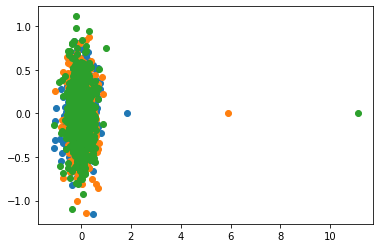

In [ ]:
for delta in [1,5,10]:  #  try also [worst_case_blob, point_and_circle, blobs]
    X, Y = worst_case_blob(num_samples=600, delta=delta)
    plot_clusters(X, Y, fignum=str(fn))

### Q1.2: While varying the parameter of `worst_case_blob`, try to select a value of $\epsilon$ that keeps the graph connected (the function `min_span_tree` can help you). What happens? Can you tell when it is a bad idea to use this approach?

A minimum spanning tree is a connected graph which minimize the sum of weights on the edges. Therefore, in order to keep the graph connected, we could choose $\epsilon$ to be the minimum weight of all edges in a min_span_tree based on the negative of the similaritiy matrix. 

Nevertheless, with blobs like worst_case_blob, the only way to get a connected graph is to fix a low threshold on similarities, therefore the graph is nearly fully connected. 

Epsilon =  3.418479914266894e-06
Proportion of edges in the graph : 0.9950111111111111


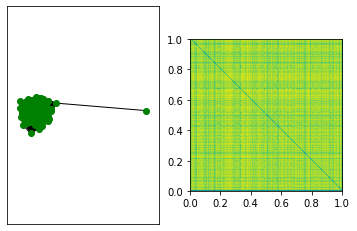

In [ ]:
n=600
var=1
X, Y = worst_case_blob(n)
similarities = build_similarity_matrix(X)
tree = min_span_tree(-similarities)
edges = np.where(tree, similarities, np.inf)
eps = np.min(edges)
print("Epsilon = ", eps)
W = build_similarity_graph(X, eps=eps)
print("Proportion of edges in the graph :", np.sum(W != 0)/W.size)
plot_graph_matrix(X, Y, W)

### Q1.3: Is it important to build a connected graph? Compare k-NN to $\epsilon$-graphs with respect to the difficulty of building a connected graph.

In a graph with k connected components, the multiplicity of eigenvalue 0 of L is equal to k. Any eigenvector associated is constant on each components, L is k-block diagonal. These eigenvectors will influence kmeans into clustering the connected components within themselves. It can create problems if we want less clusters than connected components. 


It seems that using K-neighbors to build connected graphs leads to sparser matrices than with $\epsilon$-graphs in most of the cases (except blobs), even if we use the min_span_tree method described above. This is due to the difference of scales between data. 

Proportion of edges in the graph : 0.0352


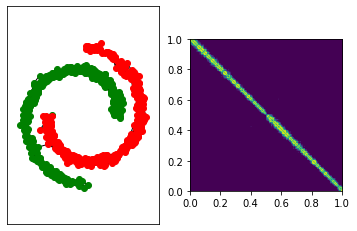

Proportion of edges in the graph : 0.29234444444444446


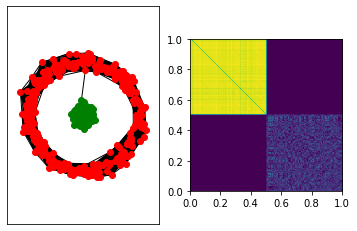

Proportion of edges in the graph : 0.4983388888888889


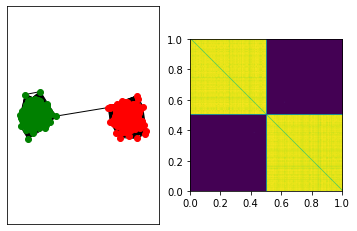

In [ ]:
n = 600
for fn in [two_moons, point_and_circle, blobs]:
    X, Y = fn(n)
    similarities = build_similarity_matrix(X)
    tree = min_span_tree(-similarities)
    eps = np.min(np.where(tree, similarities, np.inf))
    W = build_similarity_graph(X, eps=eps)
    print("Proportion of edges in the graph :", np.sum(W != 0)/W.size)
    plot_graph_matrix(X, Y, W)


Proportion of edges in the graph : 0.027433333333333334


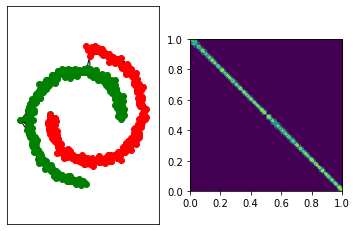

Proportion of edges in the graph : 0.10655


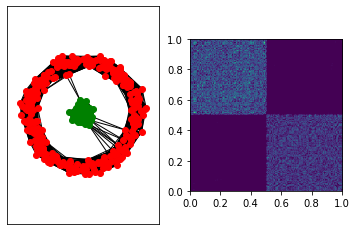

Proportion of edges in the graph : 0.5016611111111111


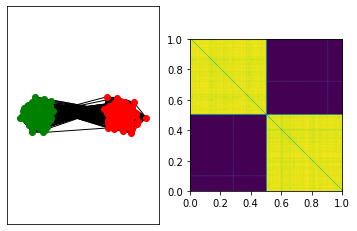

In [ ]:
n = 600
fn = [two_moons, point_and_circle, blobs]
n_neighbors = [15, 55, 300]
for i in range(3):
    X, Y = fn[i](n)
    W = build_similarity_graph(X, k=n_neighbors[i])
    print("Proportion of edges in the graph :", np.sum(W != 0)/W.size)
    plot_graph_matrix(X, Y, W)

### Q2.1: Build a graph starting from the data generated in `blobs`, and keep the graph connected. Use `spectral_clustering` to cluster the data. Motivate your choice on which eigenvectors to use and how you computed the clustering assignments from the eigenvectors. Now compute a similar clustering using the built-in k-means and compare the results.

Given that the graph is connected, the smallest eigenvalue of the laplacian is 0 with multiplicity 1. The associated eigenvector is constant and therefore useless for clustering.

According to the Rayleigh-Ritz theorem, the second eigenvector of $L$/$L_{RW}$ can be used to approximate the RatioCut/NCut in a two cluster problem. Each value in the second eigenvector gives us information about which side of the cut that node belongs. Likewise, for a k clusters problem, we can choose the k first eigenvectors.  


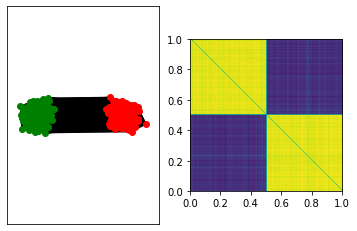

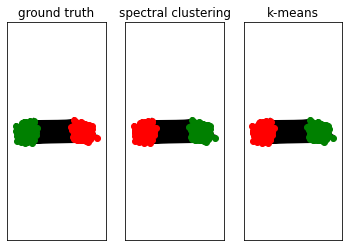

In [ ]:
# Fully connected 
X, Y = blobs(num_samples=600)
W = build_similarity_graph(X, eps=0)

num_classes = 2
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[0,1], num_classes=num_classes)
plot_graph_matrix(X, Y, W)
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

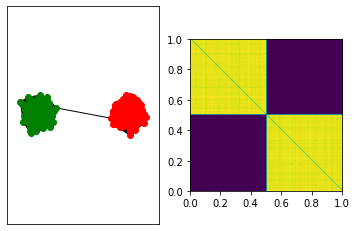

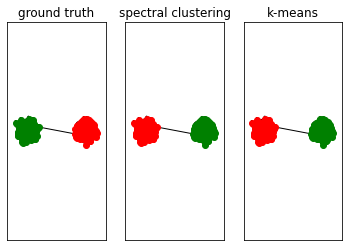

In [ ]:
# With the min_span_tree method
X, Y = blobs(num_samples=600)
similarities = build_similarity_matrix(X)
tree = min_span_tree(-similarities)
eps = np.min(np.where(tree, similarities, np.inf))
W = build_similarity_graph(X, eps=eps)

num_classes = 2
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[0,1], num_classes=num_classes)
plot_graph_matrix(X, Y, W)
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

### Q2.2: Build a graph starting from the data generated in `blobs`, but this time make it so that the two components are separated. How do you choose which eigenvectors to use in this case? Motivate your answer.


We can use the Rayleigh-Ritz method, we choose the k first eigenvectors with k the number of clusters. In this case, given that the there are two connected components, the first and second eigenvalues are equal to zero and the corresponding eigenvectors are constant over each component. Since we only want two clusters, the clustering is given by these two connected components.

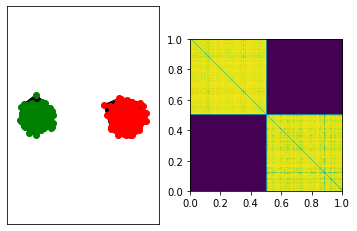

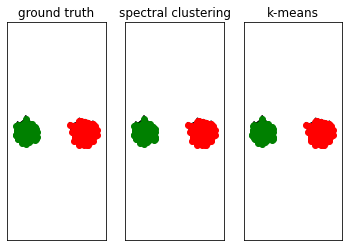

In [ ]:
X, Y = blobs(num_samples=600)
W = build_similarity_graph(X, eps=0.8)

num_classes = 2
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[0,1], num_classes=num_classes)
plot_graph_matrix(X, Y, W)
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

### Q2.3: In the function spectral_clustering, implement an automatic strategy to choose the eigenvectors to use for clustering, when chosen_eig_indices=None. Explain your strategy. Generate a dataset with 4 blobs and test your function. What happens when the variance of the blobs increase?

Thanks to Rayleigh-Ritz, if we want k clusters, we can always select the first k eigenvectors. Therefore when chosen_eig_indice is None, we can use The num_classes first eigenvectors. 

If we don't know the number of clusters, we can look for the first large gap between eigenvalues in order to find the number of clusters expressed in our data. We can observe this effect in the figure bellow and see that there is indeed four clusters.

When the variance increase, spectral clustering seems less efficient than Kmeans (I use Adjusted Rand Index to compare clusterings). The clusters are not as distinct as before, and the algorithm mixes them together.



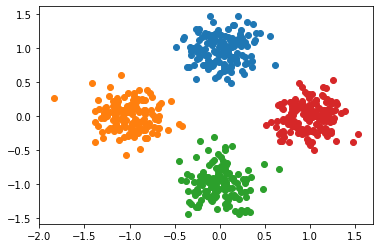

Text(0.5, 1.0, '10 first eigenvalues')

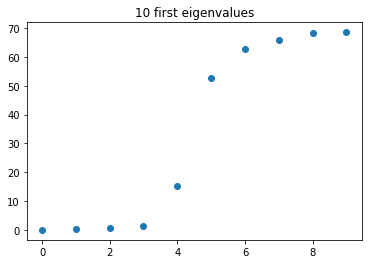

In [ ]:
from sklearn import metrics
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.2)
plot_clusters(X, Y)
plt.show()
W = build_similarity_graph(X)
L = build_laplacian(W)
E, U = np.linalg.eigh(L) 
plt.scatter(np.arange(10), np.sort(E)[:10])
plt.title('10 first eigenvalues')

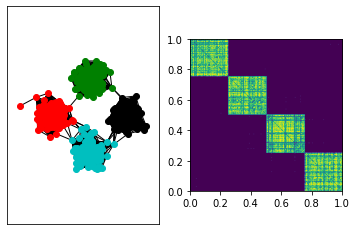

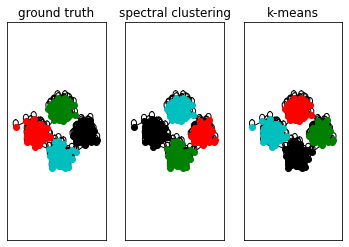

Rand Index with spectral clustering 1.0
Rand Index with k mean 1.0


In [ ]:
similarities = build_similarity_matrix(X)
tree = min_span_tree(-similarities)
eps = np.min(np.where(tree, similarities, np.inf))
W = build_similarity_graph(X, eps=eps)
plot_graph_matrix(X, Y, W)

num_classes = 4
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes)
Y_km = KMeans(num_classes).fit_predict(X)
plot_clustering_result(X, Y, L, Y_rec, Y_km)

rand_index_rec = metrics.adjusted_rand_score(Y, Y_rec)
rand_index_km = metrics.adjusted_rand_score(Y, Y_km)
print("Rand Index with spectral clustering", rand_index_rec)
print("Rand Index with k mean", rand_index_km)

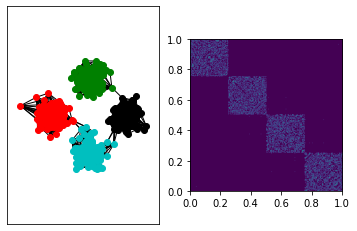

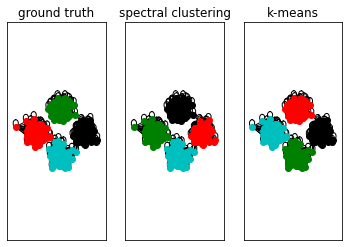

Rand Index with spectral clustering 1.0
Rand Index with k mean 1.0


In [ ]:
W = build_similarity_graph(X, k=15)

num_classes = 4
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes)
Y_km = KMeans(num_classes).fit_predict(X)

plot_graph_matrix(X, Y, W)
plot_clustering_result(X, Y, L, Y_rec, Y_km)

rand_index_rec = metrics.adjusted_rand_score(Y, Y_rec)
rand_index_km = metrics.adjusted_rand_score(Y, Y_km)
print("Rand Index with spectral clustering", rand_index_rec)
print("Rand Index with k mean", rand_index_km)

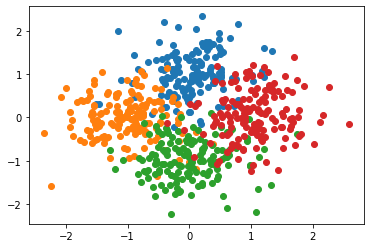

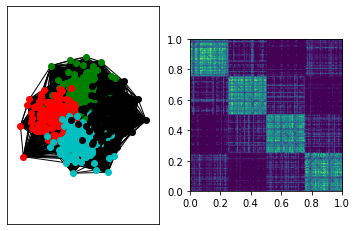

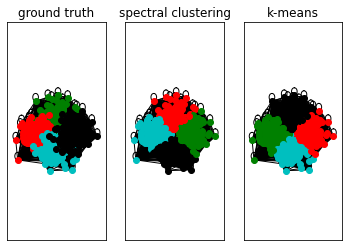

Rand Index with spectral clustering 0.6422670975347294
Rand Index with k mean 0.656538899492234


In [ ]:
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.5)
plot_clusters(X, Y)
W = build_similarity_graph(X, k=100)

num_classes = 4
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes)
Y_km = KMeans(num_classes).fit_predict(X)

plot_graph_matrix(X, Y, W)
plot_clustering_result(X, Y, L, Y_rec, Y_km)

rand_index_rec = metrics.adjusted_rand_score(Y, Y_rec)
rand_index_km = metrics.adjusted_rand_score(Y, Y_km)
print("Rand Index with spectral clustering", rand_index_rec)
print("Rand Index with k mean", rand_index_km)

### Q2.4: When you built the cluster assignment, did you use thresholding, k-means or both? Do you have any opinion on when to use each?

Once the eigenvectors are chosen, either we use a thresholding at 0, or we use kmean on the vector. It gives the clustering of each nodes. Thresholding only works when we have two clusters. 
The kmean method is more reliable than the thresholding, and works when we have more than two clusters, contrary to thresholding.

### Q2.5: Generate `two_moons` data and compare spectral clustering to k-means. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

Spectral clustering works better than k-mean in this case. This is predictable as K-mean uses euclidean distance, therefore it works best on blob clusters and has trouble with clusters of different size and density.

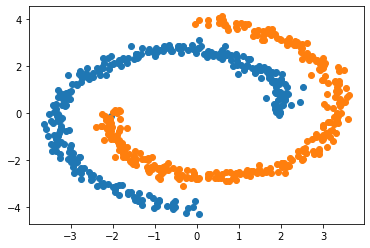

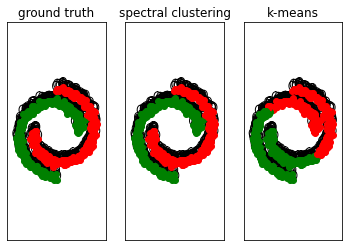

In [ ]:
X, Y = two_moons(num_samples=600)
plot_clusters(X, Y)

W = build_similarity_graph(X)

num_classes = 2
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes)
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

### Q2.6: Generate `point_and_circle` data and compare spectral clustering using the normal Laplacian and the random-walk regularized Laplacian. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

If we increase the value of sigma in `point_and_circle`, which represents the variance of each dataset, the randow walk regularized laplacian has trouble finding the good clusters.
With $L_{RW}$, we are solving the NCut problem, the cuts need to have a balanced volume (Sum of edges). With $L$, we solve the RatioCut problem where the cuts are balanced in number of vertices. Each dataset has the same number of points, but the volume is different. The point has a higher volume given that it's samples are closer to each other than in the circle.  On the other hand if we increase sigma too much, the point will merge with the cirlce and $L$ will perform badly too.


Sum of edges in each dataset (RatioCut): 6506.859864417947 60234.0305915031
Number of vertices between two datasets (NCut): 300 300


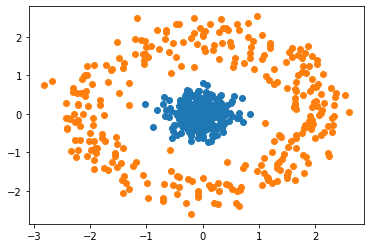

In [ ]:
X, Y = point_and_circle(num_samples=600, sigma=0.3)
plot_clusters(X, Y)
W = build_similarity_graph(X)
print("Sum of edges in each dataset (RatioCut):", W[Y==1].sum(), W[Y==0].sum())
print("Number of vertices between two datasets (NCut):", Y.sum(), (1-Y).sum())

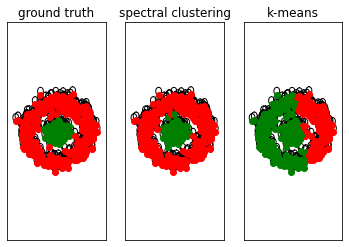

In [ ]:
num_classes = 2
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes)
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

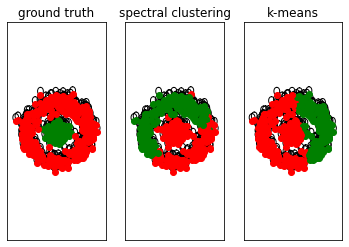

In [ ]:
num_classes = 2
L = build_laplacian(W, laplacian_normalization='rw')
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes)
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

### Q2.7: Using the function parameter_sensitivity, comment on the stability of spectral clustering when varying $\epsilon$ or k. 

Spectral clustering performs best when the number of edges in the graph is small. Therefore, a high value for epsilon and a low value for k give better results. 
We can see on the clusterings that if there are two much edges between the two clusters, the algorithm can't separate them.

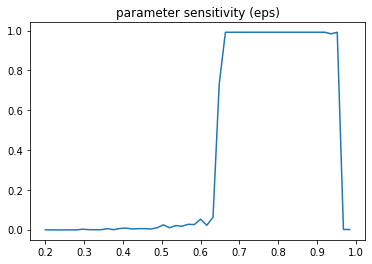

In [ ]:
"""
Choose candidate parameters
"""
parameter_type = 'eps' # choose between 'k' or 'eps'
parameter_candidate = np.arange(0.2, 1, 0.8/50)  # the number of neighbours for the graph (if 'k')
                                  # or the epsilon threshold (if 'eps')

parameter_sensitivity(parameter_type, parameter_candidate)

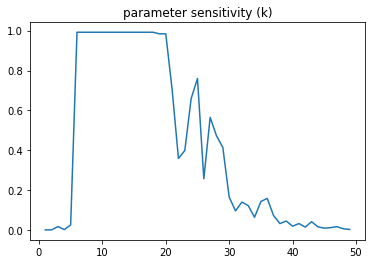

In [ ]:
"""
Choose candidate parameters
"""
parameter_type = 'k' # choose between 'k' or 'eps'
parameter_candidate = [i for i in range(1,50)]  # the number of neighbours for the graph (if 'k')
                                  # or the epsilon threshold (if 'eps')

parameter_sensitivity(parameter_type, parameter_candidate)

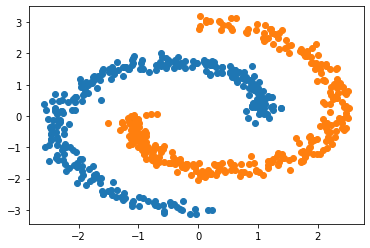

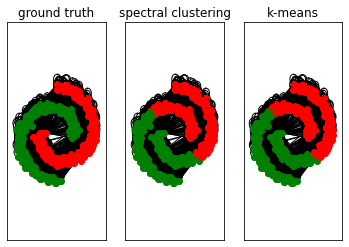

In [ ]:
# Small epsilon
X, Y = two_moons(600, 1, 0.02)
plot_clusters(X, Y)
W = build_similarity_graph(X, eps=0.2)
num_classes = 2
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes)
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

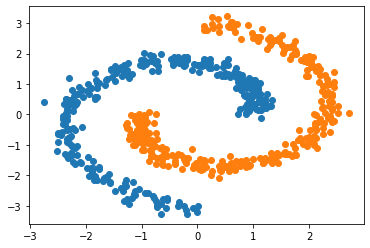

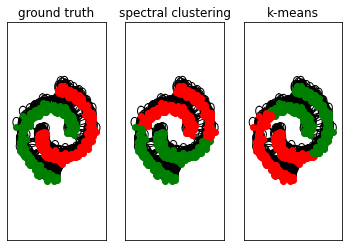

In [ ]:
# High k
X, Y = two_moons(600, 1, 0.02)
plot_clusters(X, Y)
W = build_similarity_graph(X, k=50)
num_classes = 2
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes)
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

### Q2.8: If we did not have access to "true" labels, how could we evaluate the clustering result (or what should we not use as evaluation)?

The Silhouette Coefficient is calculated using the mean intra-cluster distance and the mean nearest-cluster distance, but works better for convex datasets, which is not our case. 

We could use the value of the cut between the two datasets in order to evaluate our model, the smallest the better. Ncut seems more stable but, as we have seen previously, insights on the dataset would help to choose which cut works best. 

### Q3.1: Complete all the code necessary, and cluster the `four_elements` and `fruit_salad` images in the data folder and include here some images of the clustering.  Explain your design choices in the overall pipeline (e.g. which graph, which pre-processing...) and how you think they impact the results you are seeing. Report also at least one failure mode for the algorithm.

I choose to use k-neighbors to create the weights matrix and to use the normal Laplacian. Compared to the previous problem, we have to increase the number of neighbors in order to improve results, 50 neighbors seems to work pretty well. Then I chose eigenvectors with Rayleigh-Ritz method, we choose the number of class according to the image.

As we can see the $L_{rw}$ laplacian and RatioCut don't produce good results in this case, $L_{sym}$ is also not as good as the normal Laplacian.

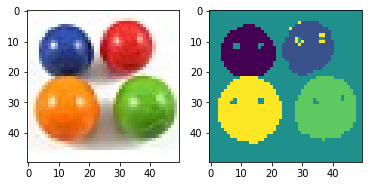

In [ ]:
num_classes = 5 # 5 classes : four ballons and the background
k = 50
filename = '/content/four_elements.bmp' 
image_segmentation(filename, num_classes, k)

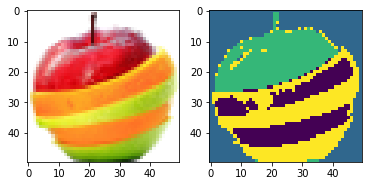

In [ ]:
num_classes = 4 # 4 classes : background, red apple, green apple and orange
filename = '/content/fruit_salad.bmp' 
k = 50
image_segmentation(filename, num_classes, k=k)

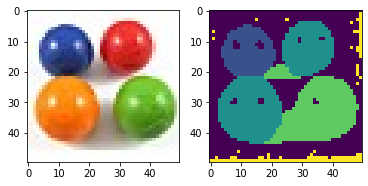

In [ ]:
num_classes = 5 # 5 classes : four ballons and the background
k = 50
filename = '/content/four_elements.bmp' 
image_segmentation(filename, num_classes, laplacian_normalization='rw')

### Q3.2: A full graph built between the pixels of a 50 × 50 image corresponds to $50^2$ nodes. Solving the full eigenvalue problem in this case would scale in the order of $2^{34}$ . Even on weak hardware this takes only seconds to minutes. Segmenting a Full HD picture of 1920 × 1080 would scale in the order of $2^{64}$ (about a month on a decent machine). Beyond that, the large picture would require to store in memory a graph over millions of nodes. A full graph on that scale requires about 1TB of memory. Can you think two simple techniques to reduce the computational and occupational cost of Spectral Clustering?


Either we make the the weight matrix sparse, by adding some conditions on edges. We could for instance add an edge between two nodes only if the two pixels are close enough. Adding this condition would reduce the computational and memory cost. 

Or we could reduce the number of pixels, using superpixels for instance. This would also reduce the computational and memory cost of the algorithm. Nevertheless, we have to choose a method which make groups pixels of the same color into one larger superpixel. Other methods of downsampling could work. The idea is to reduce the number of nodes in the graph. 

### Q3.3: Choose a larger image of your choice, and try to implement some of the scalability modifications to run spectral clustering on it. Report some examples of the results you achieve. 